# Barcelona Housing Type of Owner Data Exploration
*by Tiffany Green*

**A quick reminder about our project:** 
So, we're looking at the effect of grassroots housing justice movements' actions in Spain. We're trying to understand what material changes have happened as a result of their organizing. 

And a little reminder about the data we've been using: We've been able to find data from Barcelona City Hall that includes most of the information we've been looking for. The data is in Catalan; I'll translate titles and ownership types to English. Fortunately, the data breaks down to the neighborhood level. However, it doesn't contain the spatial geometry of the neighborhoods. So, we found an open-source geoJSON file from a pal on Github. I'll be combining that spatial data with the neighborhood codes to map. 

This is a similar project to last week's, but different in a couple ways: Firstly, the data I had last week contained all properties in Barcelona, not just the housing dwellings. So, this is only the housing data. Secondly, I did a lot of data cleaning in Excel last week. This week, I will be using a pivot function to streamline that process. Finally, this data is from 2017, rather than 2020. Barcelona City Council committed to increasing their efforts with data collection in 2018, so this version has fewer ownership types than the data in later years. It will be a good dataset to learn that function to later implement it with the more robust data. 

## Bring in the data. 

I'll bring in both the housing data and the spatial data, as well as the libraries I'll be using. 

In [1]:
#import pandas for data stuff
import pandas as pd

#import geopandas for spatial data stuff
import geopandas as gpd

#import matplotlib for plotting power
import matplotlib.pyplot as plt

In [2]:
#let geopandas read housing data
bhdf = gpd.read_file('data/2017_housing_byowner.csv')

In [3]:
#let geopandas read spatial data
bar_geom_df = gpd.read_file('data/shapefiles_barrio_barcelona.geojson')

In [4]:
#take a look at the housing data
bhdf.head()

,Any,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Tipus_propietari,Nombre,geometry
0,2017,1,Ciutat Vella,1,el Raval,Persona física. Nacionalitat espanyola,14481,None
1,2017,1,Ciutat Vella,2,el Barri Gòtic,Persona física. Nacionalitat espanyola,6098,None
2,2017,1,Ciutat Vella,3,la Barceloneta,Persona física. Nacionalitat espanyola,6606,None
3,2017,1,Ciutat Vella,4,"Sant Pere, Santa Caterina i la Ribera",Persona física. Nacionalitat espanyola,9201,None
4,2017,2,Eixample,5,el Fort Pienc,Persona física. Nacionalitat espanyola,11812,None


Ok, I'm noticing a couple things about this data. 
1. There are "No procedeix" in the property type option, which means not applicable. I'll need to see how many times and where that's included in this data. 
1. I won't be using the district information, so I can trim that. 
1. I would like the type of owner to be its own column, with the number of properties for each neighborhood in the rows below. So, I'll need to see how many property types there are and figure out how to query them to pivot that information into columns. 
1. The number column only includes the number rather than also the value or size of property, so that's helpful. 
1. Geometry column is ready to get that spatial data. Helpful. 

I'll go ahead and get a quick reminder of what the geoJSON file looks like. I've seen it before so just going to look at the beginning of the dataframe. 

In [5]:
# peek at the first few lines of geoJSON file
bar_geom_df.head()

,cartodb_id,c_distri,n_distri,c_barri,n_barri,homes,dones,area,perim,coord_x,coord_y,web_1,web_2,web_3,web_4,geometry
0,22,05,SarriÃ -Sant Gervasi,22,"Vallvidrera, el Tibidabo i les Planes",2269,2397,1.152241e+07,34375.351100,423973.042970,4.585950e+06,http://www.bcn.cat/sarria-santgervasi,http://www.bcn.cat/estadistica/catala/dades/in...,http://www.bcn.cat/estadistica/catala/dades/gu...,http://www.bcn.cat/estadistica/catala/dades/in...,"MULTIPOLYGON (((2.07327 41.41383, 2.07165 41.4..."
1,23,05,SarriÃ -Sant Gervasi,23,SarriÃ,11552,13267,3.041669e+06,10353.319052,426217.739662,4.584038e+06,http://www.bcn.cat/sarria-santgervasi,http://www.bcn.cat/estadistica/catala/dades/in...,http://www.bcn.cat/estadistica/catala/dades/gu...,http://www.bcn.cat/estadistica/catala/dades/in...,"MULTIPOLYGON (((2.12062 41.41357, 2.12065 41.4..."
2,25,05,SarriÃ -Sant Gervasi,25,Sant Gervasi - la Bonanova,11777,13797,2.235228e+06,8692.896014,427395.900450,4.584820e+06,http://www.bcn.cat/sarria-santgervasi,http://www.bcn.cat/estadistica/catala/dades/in...,http://www.bcn.cat/estadistica/catala/dades/gu...,http://www.bcn.cat/estadistica/catala/dades/in...,"MULTIPOLYGON (((2.13042 41.42065, 2.13049 41.4..."
3,43,07,Horta-GuinardÃ³,43,Horta,12590,14086,3.082269e+06,10888.952207,429246.476929,4.588141e+06,http://www.bcn.cat/horta-guinardo,http://www.bcn.cat/estadistica/catala/dades/in...,http://www.bcn.cat/estadistica/catala/dades/gu...,http://www.bcn.cat/estadistica/catala/dades/in...,"MULTIPOLYGON (((2.16268 41.44105, 2.16273 41.4..."
4,12,03,Sants-MontjuÃ¯c,12,la Marina del Prat Vermell,577,561,1.428413e+07,43242.508489,428356.498514,4.576986e+06,http://www.bcn.cat/sants-montjuic,http://www.bcn.cat/estadistica/catala/dades/in...,http://www.bcn.cat/estadistica/catala/dades/gu...,http://www.bcn.cat/estadistica/catala/dades/in...,"MULTIPOLYGON (((2.17878 41.37342, 2.17860 41.3..."


Contains the neighbrohood codes, neighborhood names, and the geometry. Those are really the only helpful bits.

## Next up, cleaning up the data. 

I'll start with the housing data. Because I'm not keeping all of the columns, I'll go ahead and trim it first. 

In [6]:
#list the column names for bhdf
bhdf.columns.to_list()

['Any',
 'Codi_Districte',
 'Nom_Districte',
 'Codi_Barri',
 'Nom_Barri',
 'Tipus_propietari',
 'Nombre',
 'geometry']

In [7]:
#trim the df to only include what's needed
bhdf_trimmed = bhdf [['Codi_Barri',
 'Nom_Barri',
 'Tipus_propietari',
 'Nombre',
 'geometry']]

In [9]:
#show me the trimmed df
bhdf_trimmed.head()

,Codi_Barri,Nom_Barri,Tipus_propietari,Nombre,geometry
0,1,el Raval,Persona física. Nacionalitat espanyola,14481,None
1,2,el Barri Gòtic,Persona física. Nacionalitat espanyola,6098,None
2,3,la Barceloneta,Persona física. Nacionalitat espanyola,6606,None
3,4,"Sant Pere, Santa Caterina i la Ribera",Persona física. Nacionalitat espanyola,9201,None
4,5,el Fort Pienc,Persona física. Nacionalitat espanyola,11812,None


Ok, this worked perfectly. Next, I want to rename the column titles. 

In [10]:
#rename trimmed df - keep geometry lowercase!!
bhdf_trimmed.columns = ['Neighborhood Code', 
                        'Neighborhood Name', 
                        'Property Type', 
                        'Number', 
                        'geometry']

In [11]:
bhdf_trimmed.head()

,Neighborhood Code,Neighborhood Name,Property Type,Number,geometry
0,1,el Raval,Persona física. Nacionalitat espanyola,14481,None
1,2,el Barri Gòtic,Persona física. Nacionalitat espanyola,6098,None
2,3,la Barceloneta,Persona física. Nacionalitat espanyola,6606,None
3,4,"Sant Pere, Santa Caterina i la Ribera",Persona física. Nacionalitat espanyola,9201,None
4,5,el Fort Pienc,Persona física. Nacionalitat espanyola,11812,None


Perfect. Next I'll clean up the geospatial dataframe. 

In [12]:
#list columns of bar_geom_df
bar_geom_df.columns.to_list()

['cartodb_id',
 'c_distri',
 'n_distri',
 'c_barri',
 'n_barri',
 'homes',
 'dones',
 'area',
 'perim',
 'coord_x',
 'coord_y',
 'web_1',
 'web_2',
 'web_3',
 'web_4',
 'geometry']

In [13]:
#trim df and show the top
bar_geom_df_trimmed = bar_geom_df [['c_barri',  'n_barri',
                                    'geometry']]
bar_geom_df_trimmed.head()

,c_barri,n_barri,geometry
0,22,"Vallvidrera, el Tibidabo i les Planes","MULTIPOLYGON (((2.07327 41.41383, 2.07165 41.4..."
1,23,SarriÃ,"MULTIPOLYGON (((2.12062 41.41357, 2.12065 41.4..."
2,25,Sant Gervasi - la Bonanova,"MULTIPOLYGON (((2.13042 41.42065, 2.13049 41.4..."
3,43,Horta,"MULTIPOLYGON (((2.16268 41.44105, 2.16273 41.4..."
4,12,la Marina del Prat Vermell,"MULTIPOLYGON (((2.17878 41.37342, 2.17860 41.3..."


In [14]:
#rename the column titles and show me
bar_geom_df_trimmed.columns = ['Neighborhood Code', 'Neighborhood Name', 
                        'geometry']
bar_geom_df_trimmed.head()

,Neighborhood Code,Neighborhood Name,geometry
0,22,"Vallvidrera, el Tibidabo i les Planes","MULTIPOLYGON (((2.07327 41.41383, 2.07165 41.4..."
1,23,SarriÃ,"MULTIPOLYGON (((2.12062 41.41357, 2.12065 41.4..."
2,25,Sant Gervasi - la Bonanova,"MULTIPOLYGON (((2.13042 41.42065, 2.13049 41.4..."
3,43,Horta,"MULTIPOLYGON (((2.16268 41.44105, 2.16273 41.4..."
4,12,la Marina del Prat Vermell,"MULTIPOLYGON (((2.17878 41.37342, 2.17860 41.3..."


Ok, I think these are in good shape! 

## Merge the dataframes

Ok, so last week I sorted and ordered these dataframes so that we could merge the tables using a for loop. Sounded like that wasn't the most efficient way to move foward. Going to use the pandas [merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) function.

In [15]:
#check datatypes for bar_geom_df_trimmed
bar_geom_df_trimmed.dtypes

Neighborhood Code       int64
Neighborhood Name      object
geometry             geometry
dtype: object

In [16]:
#check datatypes for bhdf_trimmed
bhdf_trimmed.dtypes

Neighborhood Code      object
Neighborhood Name      object
Property Type          object
Number                 object
geometry             geometry
dtype: object

In [17]:
#change bhdf_trimmed NH Code to integer
bhdf_trimmed['Neighborhood Code'] = bhdf_trimmed['Neighborhood Code'].astype(int)

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [18]:
bhdf_trimmed.dtypes

Neighborhood Code       int64
Neighborhood Name      object
Property Type          object
Number                 object
geometry             geometry
dtype: object

In [19]:
#merging housing df with geometry df df1.merge(df2, left_on='lkey', right_on='rkey')
new_bhdf = bhdf_trimmed.merge(bar_geom_df_trimmed, left_on='Neighborhood Code', right_on = 'Neighborhood Code')
new_bhdf


,Neighborhood Code,Neighborhood Name_x,Property Type,Number,geometry_x,Neighborhood Name_y,geometry_y
0,1,el Raval,Persona física. Nacionalitat espanyola,14481,None,el Raval,"MULTIPOLYGON (((2.17119 41.38659, 2.17180 41.3..."
1,1,el Raval,Persona física. Nacionalitat estrangera,1768,None,el Raval,"MULTIPOLYGON (((2.17119 41.38659, 2.17180 41.3..."
2,1,el Raval,Persona jurídica,6560,None,el Raval,"MULTIPOLYGON (((2.17119 41.38659, 2.17180 41.3..."
3,1,el Raval,No procedeix,645,None,el Raval,"MULTIPOLYGON (((2.17119 41.38659, 2.17180 41.3..."
4,2,el Barri Gòtic,Persona física. Nacionalitat espanyola,6098,None,el Barri GÃ²tic,"MULTIPOLYGON (((2.18361 41.38240, 2.18355 41.3..."
...,...,...,...,...,...,...,...
287,72,Sant Martí de Provençals,No procedeix,166,None,Sant MartÃ­ de ProvenÃ§als,"MULTIPOLYGON (((2.19660 41.42346, 2.19705 41.4..."
288,73,la Verneda i la Pau,Persona física. Nacionalitat espanyola,12066,None,la Verneda i la Pau,"MULTIPOLYGON (((2.20834 41.42868, 2.20830 41.4..."
289,73,la Verneda i la Pau,Persona física. Nacionalitat estrangera,216,None,la Verneda i la Pau,"MULTIPOLYGON (((2.20834 41.42868, 2.20830 41.4..."
290,73,la Verneda i la Pau,Persona jurídica,551,None,la Verneda i la Pau,"MULTIPOLYGON (((2.20834 41.42868, 2.20830 41.4..."


Excellent! That took *way too long* for unreasonable reasons. I'm learning so much through this process. 

I'm sure there's a way to merge that without the extra columns, but I'm going to just change it manually so I can move on. 

In [20]:
# drop the geometry_x column 
new_bhdf = new_bhdf.drop(columns=['geometry_x', 'Neighborhood Name_y'])
new_bhdf.head()

,Neighborhood Code,Neighborhood Name_x,Property Type,Number,geometry_y
0,1,el Raval,Persona física. Nacionalitat espanyola,14481,"MULTIPOLYGON (((2.17119 41.38659, 2.17180 41.3..."
1,1,el Raval,Persona física. Nacionalitat estrangera,1768,"MULTIPOLYGON (((2.17119 41.38659, 2.17180 41.3..."
2,1,el Raval,Persona jurídica,6560,"MULTIPOLYGON (((2.17119 41.38659, 2.17180 41.3..."
3,1,el Raval,No procedeix,645,"MULTIPOLYGON (((2.17119 41.38659, 2.17180 41.3..."
4,2,el Barri Gòtic,Persona física. Nacionalitat espanyola,6098,"MULTIPOLYGON (((2.18361 41.38240, 2.18355 41.3..."


In [21]:
#rename geometry column
new_bhdf.columns = ['Neighborhood Code', 
                        'Neighborhood Name', 
                        'Property Type', 
                        'Number', 
                        'geometry']

Alright, now the dataframe is cleaned up and merged. 

## Pivot the Table

I want to create columns of the property types with their corresponding numbers for the neighborhoods below it, rather than having all of the property types in one column and the numbers in another. I hear the [pivot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot.html) function does this. Let's do it!  

First, I want to see how many types of property owners there are in the data.

In [22]:
new_bhdf['Property Type'].value_counts()

Persona jurídica                            73
No procedeix                                73
Persona física. Nacionalitat  estrangera    73
Persona física. Nacionalitat  espanyola     73
Name: Property Type, dtype: int64

There are 4 types of property owners. (I'm realizing that the Property Type title is less than fitting. I'll change that later.) Looks like: Foreign Individual, Spanish Individual, Not Applicable, and Legal Person. What the last two actually mean is certainly unclear, but I will figure that out later. 

In [23]:
#try to pivot table without destroying everything 
#from documentation: df.pivot(index='foo', columns='bar', values='baz')
pivot_bhdf = new_bhdf.pivot(index='Neighborhood Code', columns = 'Property Type', values = 'Number')

In [24]:
pivot_bhdf.head()

Property Type,No procedeix,Persona física. Nacionalitat espanyola,Persona física. Nacionalitat estrangera,Persona jurídica
Neighborhood Code,,,,
1,645,14481,1768,6560
2,170,6098,850,3397
3,182,6606,677,1773
4,256,9201,1197,4016
5,407,11812,497,2954


Excellent! It worked. I lost the geometry data and Neighborhood name though. I'll just add that back on with my fresh merge functionality. But I'm not sure how the property type and neighborhood code are working together in the table above. 

In [25]:
pivot_bhdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73 entries, 1 to 73
Data columns (total 4 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   No procedeix                              73 non-null     object
 1   Persona física. Nacionalitat  espanyola   73 non-null     object
 2   Persona física. Nacionalitat  estrangera  73 non-null     object
 3   Persona jurídica                          73 non-null     object
dtypes: object(4)
memory usage: 2.9+ KB


Ok, so I changed the Neighborhood code to the index. I think that should be ok. But it may change how I merge the dfs now. Let's see. 

In [27]:
#merge this pivoted table with the geography data. 
new_bhdf = pivot_bhdf.merge(bar_geom_df_trimmed, left_on='Neighborhood Code', right_on = 'Neighborhood Code')
new_bhdf.head()

,Neighborhood Code,No procedeix,Persona física. Nacionalitat espanyola,Persona física. Nacionalitat estrangera,Persona jurídica,Neighborhood Name,geometry
0,1,645,14481,1768,6560,el Raval,"MULTIPOLYGON (((2.17119 41.38659, 2.17180 41.3..."
1,2,170,6098,850,3397,el Barri GÃ²tic,"MULTIPOLYGON (((2.18361 41.38240, 2.18355 41.3..."
2,3,182,6606,677,1773,la Barceloneta,"MULTIPOLYGON (((2.20087 41.38606, 2.20070 41.3..."
3,4,256,9201,1197,4016,"Sant Pere, Santa Caterina i la Ribera","MULTIPOLYGON (((2.18354 41.39255, 2.18461 41.3..."
4,5,407,11812,497,2954,el Fort Pienc,"MULTIPOLYGON (((2.18354 41.39255, 2.18249 41.3..."


Yay! I'm thrilled that all of this information is in the table in this way. 

## Calculate Percentages

I'm going to add a total properties and percentages columns next. 

In [28]:
new_bhdf.columns = ['Neighborhood Code', 'Not Applicable', 'Spanish Individual', 'Foreign Individual', 'Legal Person', 'Neighborhood Name','geometry']
new_bhdf.head()

,Neighborhood Code,Not Applicable,Spanish Individual,Foreign Individual,Legal Person,Neighborhood Name,geometry
0,1,645,14481,1768,6560,el Raval,"MULTIPOLYGON (((2.17119 41.38659, 2.17180 41.3..."
1,2,170,6098,850,3397,el Barri GÃ²tic,"MULTIPOLYGON (((2.18361 41.38240, 2.18355 41.3..."
2,3,182,6606,677,1773,la Barceloneta,"MULTIPOLYGON (((2.20087 41.38606, 2.20070 41.3..."
3,4,256,9201,1197,4016,"Sant Pere, Santa Caterina i la Ribera","MULTIPOLYGON (((2.18354 41.39255, 2.18461 41.3..."
4,5,407,11812,497,2954,el Fort Pienc,"MULTIPOLYGON (((2.18354 41.39255, 2.18249 41.3..."


In [29]:
#show data types of each column. 
new_bhdf.dtypes

Neighborhood Code        int64
Not Applicable          object
Spanish Individual      object
Foreign Individual      object
Legal Person            object
Neighborhood Name       object
geometry              geometry
dtype: object

In order to use the data in the 4 property ownership types, I need to change the type from objects to integers.

In [30]:
#change data type for S Ind, F Ind, NA, and L Person
new_bhdf['Spanish Individual'] = new_bhdf['Spanish Individual'].astype(int)
new_bhdf['Foreign Individual'] = new_bhdf['Foreign Individual'].astype(int)
new_bhdf['Not Applicable'] = new_bhdf['Not Applicable'].astype(int)
new_bhdf['Legal Person'] = new_bhdf['Legal Person'].astype(int)

In [31]:
#create a column for total properties, and percent of each type 
new_bhdf['Total Properties'] = new_bhdf['Not Applicable']+new_bhdf['Spanish Individual']+new_bhdf['Foreign Individual']+new_bhdf['Legal Person']
new_bhdf['Percent Spanish'] = new_bhdf['Spanish Individual']/new_bhdf['Total Properties']*100
new_bhdf['Percent Foreign'] = new_bhdf['Foreign Individual']/new_bhdf['Total Properties']*100
new_bhdf['Percent NA'] = new_bhdf['Not Applicable']/new_bhdf['Total Properties']*100
new_bhdf['Percent Legal Person'] = new_bhdf['Legal Person']/new_bhdf['Total Properties']*100
new_bhdf.head()
    

,Neighborhood Code,Not Applicable,Spanish Individual,Foreign Individual,Legal Person,Neighborhood Name,geometry,Total Properties,Percent Spanish,Percent Foreign,Percent NA,Percent Legal Person
0,1,645,14481,1768,6560,el Raval,"MULTIPOLYGON (((2.17119 41.38659, 2.17180 41.3...",23454,61.742134,7.538160,2.750064,27.969643
1,2,170,6098,850,3397,el Barri GÃ²tic,"MULTIPOLYGON (((2.18361 41.38240, 2.18355 41.3...",10515,57.993343,8.083690,1.616738,32.306229
2,3,182,6606,677,1773,la Barceloneta,"MULTIPOLYGON (((2.20087 41.38606, 2.20070 41.3...",9238,71.508985,7.328426,1.970123,19.192466
3,4,256,9201,1197,4016,"Sant Pere, Santa Caterina i la Ribera","MULTIPOLYGON (((2.18354 41.39255, 2.18461 41.3...",14670,62.719836,8.159509,1.745058,27.375596
4,5,407,11812,497,2954,el Fort Pienc,"MULTIPOLYGON (((2.18354 41.39255, 2.18249 41.3...",15670,75.379706,3.171666,2.597320,18.851308


Perfecto! I should really reorder this table. 

In [32]:
#make a list of the column names
col_titles=new_bhdf.columns.tolist()
col_titles

['Neighborhood Code',
 'Not Applicable',
 'Spanish Individual',
 'Foreign Individual',
 'Legal Person',
 'Neighborhood Name',
 'geometry',
 'Total Properties',
 'Percent Spanish',
 'Percent Foreign',
 'Percent NA',
 'Percent Legal Person']

In [33]:
#reorder columns
col_titles = ['Neighborhood Code',
              'Neighborhood Name',
              'Total Properties',
               'Spanish Individual',
               'Percent Spanish',
               'Foreign Individual',
               'Percent Foreign',
               'Legal Person',
               'Percent Legal Person',
               'Not Applicable',
               'Percent NA',
              'geometry',]


In [34]:
#pass reordered columns to dataframe
new_bhdf = new_bhdf[col_titles]
new_bhdf.sample()

,Neighborhood Code,Neighborhood Name,Total Properties,Spanish Individual,Percent Spanish,Foreign Individual,Percent Foreign,Legal Person,Percent Legal Person,Not Applicable,Percent NA,geometry
58,59,el Bon Pastor,5360,4248,79.253731,112,2.089552,945,17.630597,55,1.026119,"MULTIPOLYGON (((2.20834 41.42868, 2.20673 41.4..."


This table is exactly how I want it. 

## Create a new chart

I'm going to explore some charts that I have yet to use. I'd like to try a bar chart with the ownership types grouped, the x-axis showing the neighborhood names, and the y-axis the percentages. 

I'll choose the top 5 neighborhoods with the most foreign ownership. A smaller subset will allow me to actually see the data. Last week, I did a histogram of each neighborhood, which ended up being difficult to read. 

In [35]:
#sort by foreign ownership
fpercent = new_bhdf.sort_values(by='Percent Foreign',ascending = False)

In [36]:
#show table of top 5 fper and create a new variable
top_fper = fpercent.head(5)
top_fper

,Neighborhood Code,Neighborhood Name,Total Properties,Spanish Individual,Percent Spanish,Foreign Individual,Percent Foreign,Legal Person,Percent Legal Person,Not Applicable,Percent NA,geometry
68,69,Diagonal Mar i el Front MarÃ­tim del Poblenou,6415,4806,74.918161,524,8.168355,1037,16.165238,48,0.748246,"MULTIPOLYGON (((2.22281 41.40575, 2.22341 41.4..."
3,4,"Sant Pere, Santa Caterina i la Ribera",14670,9201,62.719836,1197,8.159509,4016,27.375596,256,1.745058,"MULTIPOLYGON (((2.18354 41.39255, 2.18461 41.3..."
1,2,el Barri GÃ²tic,10515,6098,57.993343,850,8.083690,3397,32.306229,170,1.616738,"MULTIPOLYGON (((2.18361 41.38240, 2.18355 41.3..."
0,1,el Raval,23454,14481,61.742134,1768,7.538160,6560,27.969643,645,2.750064,"MULTIPOLYGON (((2.17119 41.38659, 2.17180 41.3..."
2,3,la Barceloneta,9238,6606,71.508985,677,7.328426,1773,19.192466,182,1.970123,"MULTIPOLYGON (((2.20087 41.38606, 2.20070 41.3..."


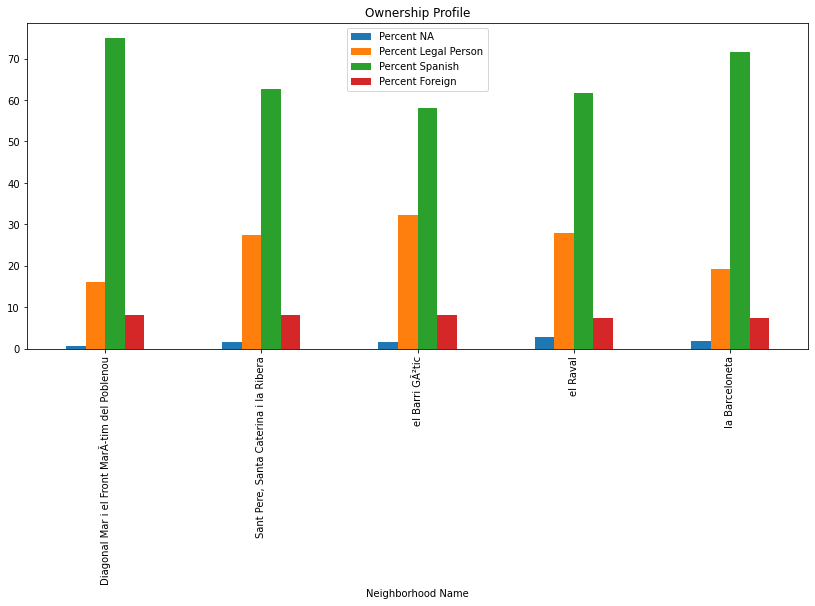

In [37]:
top_fper.plot.bar(figsize = (14, 6), x = 'Neighborhood Name', y = {'Percent Spanish', 'Percent Foreign' , 'Percent Legal Person' , 'Percent NA' }, title = 'Ownership Profile' )

I'd like to plot those neighborhoods as well. I'm curious if they're close to each other. 

When trying to plot this, I couldn't get it to plot the geo data. That's because I merged the geodataframe into the pandas dataframe. So I need to change it into a geopandas dataframe. 

In [46]:
# import GeoDataFrame from geopandas
from geopandas import GeoDataFrame

In [47]:
# change df into gdf
top_fper = GeoDataFrame(top_fper)

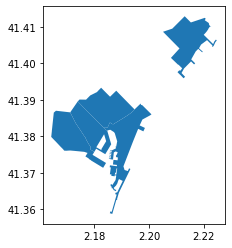

In [49]:
#plot the NH with top foreign ownership
top_fper.plot()

And there it is! The plot for this assingment isn't super sophisticated today. That's ok. I really needed to focus on the data manipulation and streamlining the process. 

I wonder if there's a correlation between these neighborhoods and the neighborhoods with higher eviciton rates. I also how these percentages changed in the years since the housing crash in 2007. Interesting things I'll be looking into as we move forward with the project. 

We will try to use these merge and pivot functions a lot in the future. So, here are a few final thoughts: 
* I wonder if merging the data from the pandas into the geopandas will make it easier on me down the road. 
* It'll likely be easier to pivot before merging so I don't have to rename and reorder the table multiple times. 
* When you create a new column of percentages, those values are created as floats. I wonder if there's a way to make them integers from the start. 
* When I do the Command + click for multiple cursors, one cursor will delete faster one character quicker than the other. I must be doing something wrong with that. 